In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import models
import build

In [2]:
#base = tf.keras.models.load_model("TT_resnet101v2_swish_pad_same_first_conv_k3_stride_1_conv_no_bias_E_arc_emb512_dr04_sgd_l2_5e4_bs384_ms1m_bnm09_bne1e4_cos16_basic_agedb_30_epoch_44_batch_2000_0.985000.h5")
#base.summary()

In [3]:
base, trainable = models.ResNet50()

In [4]:
dataset, n = datasets.SCUTFBP5500(
    input_shape=base.input_shape,
    features="./14x14/"
)
#dataset, n = datasets.MEBeauty(
    #ratings="./MEBeauty_Distribution2.csv",
    #input_shape=base.input_shape
#)
#dataset.generate(model=base, augment=0)

In [5]:
model = build.build(
    base.output_shape,
    trainable=trainable,
    n=n,
    mlp_weights="./mlp.hdf5",
    augment=False,
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14, 14, 1024)]    0         
                                                                 
 model_1 (Functional)        (None, 1, 1, 2048)        14987264  
                                                                 
 model_2 (Functional)        (None, 5)                 271621    
                                                                 
Total params: 15,258,885
Trainable params: 15,232,005
Non-trainable params: 26,880
_________________________________________________________________


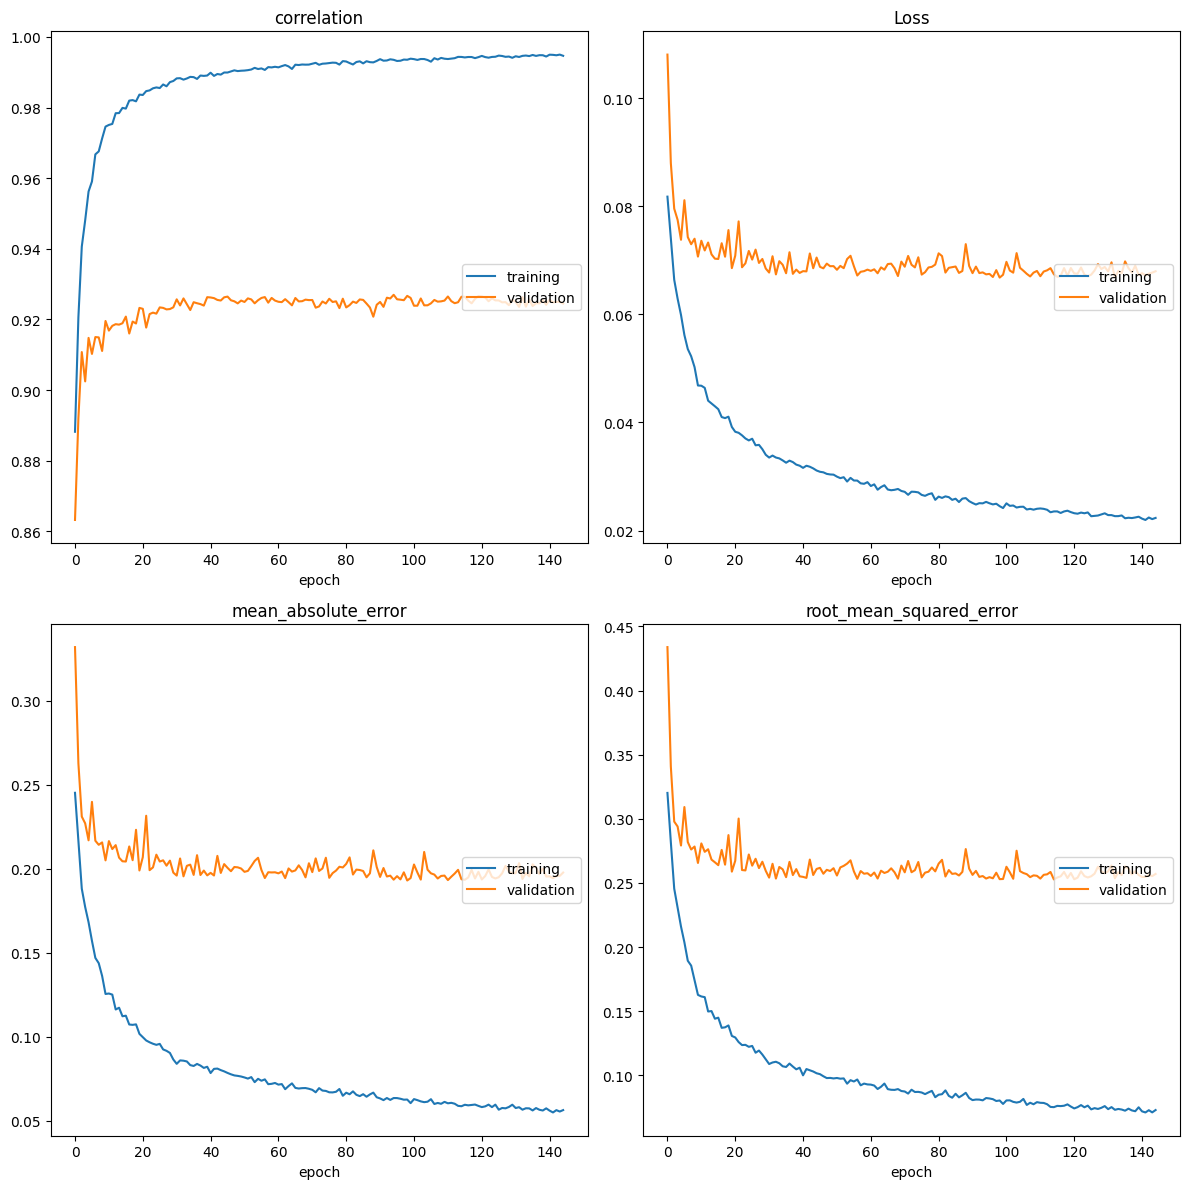

correlation
	training         	 (min:    0.888, max:    0.995, cur:    0.995)
	validation       	 (min:    0.863, max:    0.927, cur:    0.925)
Loss
	training         	 (min:    0.022, max:    0.082, cur:    0.022)
	validation       	 (min:    0.067, max:    0.108, cur:    0.068)
mean_absolute_error
	training         	 (min:    0.055, max:    0.245, cur:    0.056)
	validation       	 (min:    0.193, max:    0.332, cur:    0.198)
root_mean_squared_error
	training         	 (min:    0.071, max:    0.320, cur:    0.073)
	validation       	 (min:    0.253, max:    0.434, cur:    0.257)
104/104 [==============================] - 5s 44ms/step - loss: 0.0223 - mean_absolute_error: 0.0563 - root_mean_squared_error: 0.0729 - correlation: 0.9947 - val_loss: 0.0680 - val_mean_absolute_error: 0.1978 - val_root_mean_squared_error: 0.2570 - val_correlation: 0.9245
Time: 15.6455


In [6]:
metrics = [losses.MeanAbsoluteError(n=n),
           losses.RootMeanSquaredError(n=n),
           losses.PearsonCorrelation(n=n)]#,
           #losses.MeanAbsoluteError(n=n, mode="var"),
           #losses.RootMeanSquaredError(n=n, mode="var"),
           #losses.PearsonCorrelation(n=n, mode="var"),
           #losses.MeanAbsoluteError(n=n, mode="skew"),
           #losses.RootMeanSquaredError(n=n, mode="skew"),
           #losses.PearsonCorrelation(n=n, mode="skew")]

#loss = tf.keras.losses.MeanSquaredError()
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = losses.SquaredEarthMoversDistance()

#dataset.shuffle()
build.compile(model, loss, metrics=metrics, learning_rate=0.00011)
time = build.train(
    model, 
    dataset.train, 
    dataset.test,
    monitor="val_correlation",
    callbacks=[PlotLossesKerasTF()]
)

print(f"Time: {np.round(time, 4)}")

In [7]:
#np.round(model.evaluate(dataset.test), 6)
y_pred = model.predict(dataset.test.x)
print(metrics[0](dataset.test.y, y_pred))
print(metrics[1](dataset.test.y, y_pred))
print(metrics[2](dataset.test.y, y_pred))
np.save("y_pred_16.npy", y_pred)

69/69 [==============================] - 5s 64ms/step
tf.Tensor(0.19357681, shape=(), dtype=float32)
tf.Tensor(0.25608543, shape=(), dtype=float32)
tf.Tensor([[0.92703354]], shape=(1, 1), dtype=float32)


In [8]:
#model.save_weights("mlp.hdf5")

In [9]:
m = np.zeros(dataset.test.y.shape)

k = 5
for i in range(k):
    m += np.load(f"y_pred_1{i+1}.npy")
m /= k

print(metrics[0](dataset.test.y, m))
print(metrics[1](dataset.test.y, m))
print(metrics[2](dataset.test.y, m))

tf.Tensor(0.18783164, shape=(), dtype=float32)
tf.Tensor(0.24747826, shape=(), dtype=float32)
tf.Tensor([[0.931106]], shape=(1, 1), dtype=float32)
